### Mixed online/offline Bayesian Optimization in Ax

This uses a synthetic function to illustrate mixed online/offline Bayesian Optimization using a multi-task Gaussian Process in Ax.

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, norm
import time
from typing import List, Optional

from ax.core.data import Data
from ax.core.observation import ObservationData, ObservationFeatures, observations_from_data
from ax.core.optimization_config import OptimizationConfig
from ax.core.search_space import SearchSpace
from ax.core.objective import Objective
from ax.runners.synthetic import SyntheticRunner
from ax.modelbridge.random import RandomModelBridge
from ax.core.outcome_constraint import OutcomeConstraint
from ax.core.types import ComparisonOp
from ax.core.parameter import RangeParameter, ChoiceParameter, ParameterType
from ax.core.simple_experiment import SimpleExperiment
from ax.core.multi_type_experiment import MultiTypeExperiment
from ax.metrics.hartmann6 import Hartmann6Metric
from ax.modelbridge.factory import get_sobol, get_GPEI, get_thompson, get_uniform, get_MTGP
from ax.modelbridge.numpy import NumpyModelBridge
from ax.metrics.noisy_function import NoisyFunctionMetric
from ax.modelbridge.transforms.base import Transform, TConfig
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
from ax.core.generator_run import GeneratorRun
from ax.plot.diagnostic import interact_batch_comparison, _get_batch_comparison_plot_data
from ax.plot.render import plot_config_to_html
from ax.utils.notebook.plotting import init_notebook_plotting, render
from IPython.core.display import display, HTML

In [2]:
# Create simple search space for [0,1] parameters x1, x2,...
param_names = [f"x{i}" for i in range(6)]
parameters=[
    RangeParameter(
        name=param_names[i], parameter_type=ParameterType.FLOAT, lower=0.0, upper=1.0
    )
    for i in range(6)
]
search_space=SearchSpace(parameters=parameters)

In [3]:
# Constraint metric based on norm of parameters
class NormConstraint(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return float(np.sqrt(np.sum(x ** 2)))

# Create metrics identical to online objective/constraint
# with artificial offline bias
class OfflineHartmann6Metric(Hartmann6Metric):
    def f(self, x: np.ndarray) -> float:
        raw_res = super().f(x)
        m = -0.35
        if raw_res < m:
            return (1.5* (raw_res - m)) + m
        else:
            return (6.0 * (raw_res - m)) + m

class OfflineNormConstraint(NormConstraint):
    def f(self, x: np.ndarray) -> float:
        raw_res = super().f(x)
        m = 1.25
        if raw_res < m:
            return (0.8 * (raw_res - m)) + m
        else:
            return (4 * (raw_res - m)) + m

In [4]:
# Create a MultiTypeExperiment for doing mixed online/offline experimentation
def get_experiment():
    noise_sd = 0.1
    
    # Define objective/constraint w.r.t online metrics.
    online_objective = Hartmann6Metric("objective", param_names=param_names, noise_sd=noise_sd)
    online_constraint = NormConstraint("constraint", param_names=param_names, noise_sd=noise_sd)
    opt_config = OptimizationConfig(
        Objective(online_objective, minimize=True),
        [OutcomeConstraint(online_constraint, op=ComparisonOp.LEQ, bound=1.25, relative=False)]
    )
    
    # Init experiment
    exp = MultiTypeExperiment(
        name="mt_exp",
        search_space=search_space,
        default_trial_type="online",
        default_runner=SyntheticRunner(),
        optimization_config=opt_config,
    )
    
    # Establish offline trial type and how to deploy it
    exp.add_trial_type("offline", SyntheticRunner())
    
    # Offline equivalents meant to approximate online metrics
    offline_metrics = [
        OfflineHartmann6Metric("offline_objective", param_names=param_names, noise_sd=noise_sd),
        OfflineNormConstraint("offline_constraint", param_names=param_names, noise_sd=noise_sd)
    ]
    
    # Associate each offline metric with corresponding online metric
    # This comes in handy for the modeling phase
    for metric in offline_metrics:
        exp.add_tracking_metric(metric, "offline", metric.name[len("offline_"):])

    # Add a noiseless equivalent for each metric
    for name, metric in dict(exp.metrics).items():
        noiseless_metric = deepcopy(metric)
        noiseless_metric._name = name + "_noiseless"
        noiseless_metric.noise_sd = 0.0
        
        trial_type = exp.metric_to_trial_type[name]
        if trial_type == "online":
            exp.add_tracking_metric(noiseless_metric, trial_type)
        else:
            canonical_name = noiseless_metric.name[len("offline_"):]
            exp.add_tracking_metric(noiseless_metric, trial_type, canonical_name)
    return exp
e = get_experiment()

#### The true function and simulator bias

We seek here to optimize the Hartmann6 function. We are able to either make an "online" evaluation, which gives us a noisy but unbiased estimate of the function value at that point, or an "offline" evaluation, which gives a noisy and biased estimate. Here, bias is added by passing the true values through a sigmoid function. This figure compares "online" measurements and "offline" measurements at a set of randomly selected design points:

In [5]:
uniform_generator = RandomModelBridge(
    search_space=search_space,
    model=UniformGenerator(),
    transforms=[],
)
gr = uniform_generator.gen(50)
exp = get_experiment()
exp.new_batch_trial(trial_type="online", generator_run=gr).run()
exp.new_batch_trial(trial_type="offline", generator_run=gr).run()
data = exp.fetch_data()
observations = observations_from_data(exp, data)

render(interact_batch_comparison(observations, 0, 1))

#### The Bayesian optimization loop

In [6]:
n_reps = 1  # Number of repeated experiments, each with independent observation noise
n_init_online = 5  # Size of the quasirandom initialization run online
n_init_offline = 20  # Size of the quasirandom initialization run offline
n_batch_online = 5  # Batch size for BO selected points to be run online
n_batch_offline = 20  # Batch size for BO selected to be run offline
n_batches = 1  # Number of optimized BO batches

In [7]:
def max_utility_from_GP(n, m, experiment, search_space, gr):
    obsf = []
    for arm in gr.arms:
        params = deepcopy(arm.params)
        params['trial_type'] = 'online'
        obsf.append(ObservationFeatures(parameters=params))
    # Make predictions
    f, cov = m.predict(obsf)
    # Compute expected utility
    mu_c = np.array(f['constraint'])
    sigma_c = np.sqrt(cov['constraint']['constraint'])
    pfeas = norm.cdf((1.25 - mu_c) / sigma_c)
    u = -np.array(f['objective']) * pfeas
    best_arm_indx = np.flip(np.argsort(u))[:n]
    gr_new = GeneratorRun(
        arms = [
            gr.arms[i] for i in best_arm_indx
        ],
        weights = [1.] * n,
    )
    return gr_new

In [8]:
def run_online_only_bo():
    t1 = time.time()
    ### Do BO with online only
    ## Quasi-random initialization
    exp_online = get_experiment()
    m = get_sobol(search_space, scramble=False)
    gr = m.gen(n=n_init_online)
    exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Online-only batch', b, time.time() - t1)
        # Fit the GP
        m = get_GPEI(
            experiment=exp_online,
            data=exp_online.fetch_data(),
            search_space=search_space,
        )
        # Generate the new batch
        gr = m.gen(
            n=n_batch_online,
            search_space=search_space,
            optimization_config=exp_online.optimization_config,
        )
        exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    ## Extract true objective and constraint at each iteration
    df = exp_online.fetch_data().df
    obj = df[df['metric_name'] == 'objective_noiseless']['mean'].values
    con = df[df['metric_name'] == 'constraint_noiseless']['mean'].values
    return obj, con

def run_mtbo():
    t1 = time.time()
    # Do BO with the MTGP
    online_trials = []
    ## Quasi-random initialization, online and offline
    exp_multitask = get_experiment()
    # Online points
    m = get_sobol(search_space, scramble=False)
    gr = m.gen(
        n=n_init_online,
    )
    tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
    tr.run()
    online_trials.append(tr.index)
    # Offline points
    m = get_sobol(search_space, scramble=False)
    gr = m.gen(
        n=n_init_offline,
    )
    exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Multi-task batch', b, time.time() - t1)
        # Fit the MTGP
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=search_space,
        )

        # Finding the best points for the online task
        gr = m.gen(
            n=n_batch_offline,
            optimization_config=exp_multitask.optimization_config,
            fixed_features=ObservationFeatures(parameters={'trial_type': 'online'}),
        )
#         raise ValueError((gr.arms,n_batch_offline) )

        # But launch them offline
        exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
        # Update the model
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=search_space,
        )
        
        # Select max-utility points from the offline batch to generate an online batch
        gr = max_utility_from_GP(
            n=n_batch_online,
            m=m,
            experiment=exp_multitask,
            search_space=search_space,
            gr=gr,
        )
        tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
        tr.run()
        online_trials.append(tr.index)
    # Extract true objective at each online iteration
    obj = np.array([])
    con = np.array([])
    for tr in online_trials:
        df_t = exp_multitask.trials[tr].fetch_data().df
        df_tobj = df_t[df_t['metric_name'] == 'objective_noiseless']
        obj = np.hstack((obj, df_tobj['mean'].values))
        df_tcon = df_t[df_t['metric_name'] == 'constraint_noiseless']
        con = np.hstack((con, df_tcon['mean'].values))
    return obj, con

In [9]:
runners = {
    'GP_online': run_online_only_bo,
    'MTGP': run_mtbo,
}
iteration_objectives = {k: [] for k in runners}
iteration_constraints = {k: [] for k in runners}
for rep in range(n_reps):
    print('Running rep', rep)
    for k, r in runners.items():
        obj, con = r()
        iteration_objectives[k].append(obj)
        iteration_constraints[k].append(con)

for k, v in iteration_objectives.items():
    iteration_objectives[k] = np.array(v)
    iteration_constraints[k] = np.array(iteration_constraints[k])

Running rep 0
Online-only batch 0 0.006375551223754883
Multi-task batch 0 0.03579115867614746


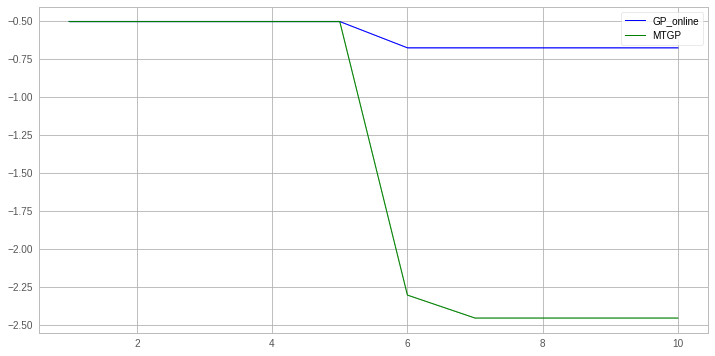

In [10]:
# Plot the results
means = {}
sems = {}
for m, obj in iteration_objectives.items():
    x = obj.copy()
    z = iteration_constraints[m].copy()
    x[z > 1.25] = np.Inf
    best_obj = np.array([np.minimum.accumulate(obj_i) for obj_i in x])
    means[m] = best_obj.mean(axis=0)
    sems[m] = best_obj.std(axis=0) / np.sqrt(best_obj.shape[0])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
x = np.arange(1, len(means['GP_online']) + 1)
colors = ['b', 'g', 'purple', 'k']
methods = ['GP_online', 'MTGP']
for i, m in enumerate(methods):
    ax.plot(x, means[m], ls='-', c=colors[i])
    ax.fill_between(x, means[m] - 2 * sems[m], means[m] + 2 * sems[m], color=colors[i], alpha=0.3)
ax.legend(methods)